In [38]:
import pandas as pd
import numpy as np
import os, sys
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from skfeature.function.similarity_based import fisher_score
from scipy.stats import entropy
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.special import gamma,psi,digamma
from numpy import pi
import math
import os
from numpy import linalg as LA
import time


In [39]:
def _mi_dc(x, y, k):
    """
    Calculates the mututal information between a continuous vector x and a
    disrete class vector y.
    This implementation can calculate the MI between the joint distribution of
    one or more continuous variables (X[:, 1:3]) with a discrete variable (y).
    Thanks to Adam Pocock, the author of the FEAST package for the idea.
    Brian C. Ross, 2014, PLOS ONE
    Mutual Information between Discrete and Continuous Data Sets
    """

    y = y.flatten()
    n = x.shape[0]
    classes = np.unique(y)
    knn = NearestNeighbors(n_neighbors=k)
    # distance to kth in-class neighbour
    d2k = np.empty(n)
    # number of points within each point's class
    Nx = []
    for yi in y:
        Nx.append(np.sum(y == yi))

    # find the distance of the kth in-class point
    for c in classes:
        mask = np.where(y == c)[0]
        knn.fit(x[mask, :])
        d2k[mask] = knn.kneighbors()[0][:, -1]

    # find the number of points within the distance of the kth in-class point
    knn.fit(x)
    m = knn.radius_neighbors(radius=d2k, return_distance=False)
    m = [i.shape[0] for i in m]

    # calculate MI based on Equation 2 in Ross 2014
    MI = psi(n) - np.mean(psi(Nx)) + psi(k) - np.mean(psi(m))
    return MI
def _nearest_distances(X, k=1):
    """
    Returns the distance to the kth nearest neighbor for every point in X
    """

    knn = NearestNeighbors(n_neighbors=k, metric='chebyshev')
    knn.fit(X)
    # the first nearest neighbor is itself
    d, _ = knn.kneighbors(X)
    # returns the distance to the kth nearest neighbor
    return d[:, -1]
def _entropy(X, k=1):
    """
    Returns the entropy of the X.
    Written by Gael Varoquaux:
    https://gist.github.com/GaelVaroquaux/ead9898bd3c973c40429
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The data the entropy of which is computed
    k : int, optional
        number of nearest neighbors for density estimation
    References
    ----------
    Kozachenko, L. F. & Leonenko, N. N. 1987 Sample estimate of entropy
    of a random vector. Probl. Inf. Transm. 23, 95-101.
    See also: Evans, D. 2008 A computationally efficient estimator for
    mutual information, Proc. R. Soc. A 464 (2093), 1203-1215.
    and:
    Kraskov A, Stogbauer H, Grassberger P. (2004). Estimating mutual
    information. Phys Rev E 69(6 Pt 2):066138.
    F. Perez-Cruz, (2008). Estimation of Information Theoretic Measures
    for Continuous Random Variables. Advances in Neural Information
    Processing Systems 21 (NIPS). Vancouver (Canada), December.
    return d*mean(log(r))+log(volume_unit_ball)+log(n-1)-log(k)
    """

    # Distance to kth nearest neighbor
    r = _nearest_distances(X, k)
    n, d = X.shape
    volume_unit_ball = (np.pi ** (.5 * d)) / gamma(.5 * d + 1)
    return (d * np.mean(np.log(r + np.finfo(X.dtype).eps)) +
            np.log(volume_unit_ball) + psi(n) - psi(k))

In [40]:
def find_Q_p():
    scaler = MinMaxScaler((-1, 1))
    df = pd.read_csv('parkinsons.data')
    df.head()
    a =  df.loc[:, df.columns != 'status'].values[:, 1:]
    b = df.loc[:, 'status'].values
    features = df.loc[:, df.columns != 'status'].values[:, 1:].reshape(195,22)
    labels = df.loc[:, 'status'].values.reshape(195,1)
    df = np.hstack((features,labels))
    df = pd.DataFrame(df, columns = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
    'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
    'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
    'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA',
    'spread1', 'spread2', 'D2', 'PPE', 'status'])
    from sklearn.metrics.cluster import normalized_mutual_info_score
    p_ig = mutual_info_classif(features,labels) #1x22
    
    # p_fs = fisher_score.fisher_score(features,labels)
    print(p_ig)
    Q = np.zeros((22,22))
    k = 5 #7
    # p_ig = []
    # #print(np.array(features))
    # #print(_mi_dc(np.array(features), labels, k))
    # for i in range(22):
    #     p_ig.append(_mi_dc(np.array(features[:,i]).reshape(1,195).T, labels, k))
    for i in range(22):
        for j in range(22):
            H = _entropy(np.array([a[:,i]],dtype="float64").reshape(195,1),k) + _entropy(np.array([a[:,j]],dtype="float64").reshape(195,1),k)
            #print(np.array(features[:,i]).reshape(1,195).shape)
            #print(np.vstack((features[:,i],features[:,j])).T.shape)
            tmp1 = _mi_dc(np.array(features[:,i]).reshape(1,195).T, labels, k)
            tmp2 = _mi_dc(np.array(features[:,j]).reshape(1,195).T, labels, k)
            #print(tmp1)
            #print(np.vstack((features[:,i],features[:,j])).T)
            tmp3 = _mi_dc(np.vstack((features[:,i],features[:,j])).T, labels, k)
            tmp = tmp1+tmp2-tmp3
            #print(tmp1+tmp2-tmp3)
            Q[i,j] = max(0,tmp/H)
    return np.array(p_ig).reshape(1,22),Q,features,labels

In [41]:
p,Q,features,labels = find_Q_p()
w, v = LA.eig(Q)
w
xi = -min(0,min(w))
xi

[0.20659267 0.14071299 0.17408837 0.11305195 0.19648869 0.09860681
 0.11294045 0.0893201  0.09818314 0.10003666 0.10877532 0.11295902
 0.18084064 0.11043589 0.12330283 0.13246159 0.03700343 0.09511555
 0.22136783 0.19200151 0.01791333 0.25398246]


0.28726076668625

In [42]:
p

array([[0.20659267, 0.14071299, 0.17408837, 0.11305195, 0.19648869,
        0.09860681, 0.11294045, 0.0893201 , 0.09818314, 0.10003666,
        0.10877532, 0.11295902, 0.18084064, 0.11043589, 0.12330283,
        0.13246159, 0.03700343, 0.09511555, 0.22136783, 0.19200151,
        0.01791333, 0.25398246]])

In [43]:
Q = xi*np.eye(22) + Q
Q

array([[3.08421105e-01, 8.74271224e-03, 1.51789980e-02, 0.00000000e+00,
        4.20775865e-02, 1.88592552e-02, 2.71521402e-02, 7.23994328e-02,
        5.34990935e-02, 0.00000000e+00, 7.99028215e-02, 6.94509720e-02,
        8.03872265e-02, 2.25210740e-02, 4.00653920e-02, 0.00000000e+00,
        0.00000000e+00, 1.29379564e-02, 1.63401792e-02, 2.68880117e-02,
        0.00000000e+00, 7.10484864e-02],
       [8.74271224e-03, 2.97688278e-01, 6.38875712e-03, 1.24125310e-01,
        4.23793011e-02, 2.07534523e-02, 2.67530920e-02, 2.98886811e-02,
        2.96428369e-02, 0.00000000e+00, 4.14509623e-02, 4.86658485e-02,
        5.22220712e-02, 2.19255177e-02, 3.61616070e-02, 0.00000000e+00,
        1.31268078e-03, 1.30646608e-02, 2.58185900e-02, 2.35019600e-02,
        0.00000000e+00, 6.18439388e-02],
       [1.51789980e-02, 6.38875712e-03, 3.04153796e-01, 0.00000000e+00,
        4.15965520e-02, 9.44559076e-03, 1.68643160e-02, 6.29592194e-02,
        3.53609741e-02, 0.00000000e+00, 5.01543636e-02

In [44]:
np.linalg.det(Q)
w, v = LA.eig(Q)
w

array([6.76883616e-01, 3.66080699e-16, 4.98340776e-01, 4.51531960e-01,
       1.29213274e-01, 1.39157580e-01, 4.03478846e-01, 1.78885155e-01,
       3.57278256e-01, 2.26849969e-01, 2.35687183e-01, 3.19615512e-01,
       3.11773854e-01, 2.56517524e-01, 2.65355524e-01, 3.02297267e-01,
       2.78713907e-01, 2.83148537e-01, 2.92235166e-01, 2.86366195e-01,
       2.88981139e-01, 2.88323011e-01])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[2.81303230e-07 2.40719284e-07 2.63903694e-07 6.49811318e-02
 6.28574566e-07 5.26758228e-02 5.89742744e-02 5.60017096e-02
 6.04368031e-02 6.26860967e-06 6.40095167e-02 6.15601873e-02
 8.27119516e-02 6.33809136e-02 6.78481479e-02 1.61148639e-07
 3.34559295e-02 4.50786810e-02 7.66459052e-02 8.04018207e-02
 2.85209117e-02 1.03308449e-01]
-4.440892098500626e-16
[0.15305051]
GDA:  6.096260070800781


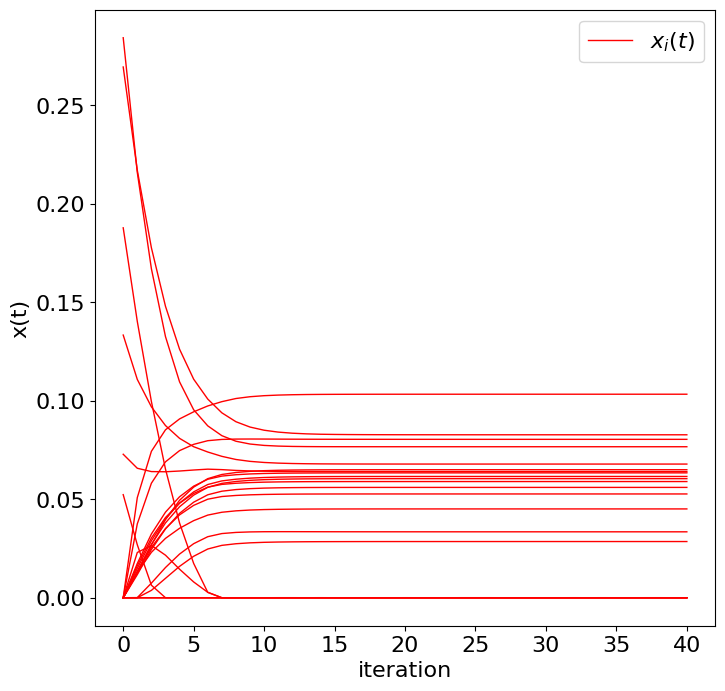

In [45]:
import numpy as np
from autograd import grad
import autograd.numpy as np1
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds,BFGS
import random

# print(Q)
# print(p)
def f(x):
    return (np1.dot(np1.dot(x,Q),x.T))/(np1.dot(p,x.T))
def g1(x):
    return np1.sum(x) - 1
f_dx = grad(f)
g1_dx = grad(g1)
cons = ({'type': 'eq',
          'fun' : lambda x: np.array([g1(x)]),
          'jac' : lambda x: np.array([g1_dx(x)])})
bounds = Bounds([0 for i in range(22)], [np.inf for i in range(22)])
def rosen(x,y):
    """The Rosenbrock function"""
    return np.sqrt(np.sum((x-y)**2))
def find_min(y,n):
    x = np.random.rand(1,n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point",hess = BFGS(),
                constraints=cons,method='trust-constr', options={'disp': False},bounds=bounds)
    return res.x
def run_nonsmooth1(x, max_iters, f, f_dx,n):
    res = []
    val = []
    lda = 0.1 #1e9
    sigma = 0.1 #100
    K = np.random.rand(1,1)
    res.append(x)
    val.append(f(x))
    x_pre = x
    for t in range(max_iters):
        y = x - lda*f_dx(x)
        x_pre = x.copy()
        x = find_min(y,n)
        if f(x) - f(x_pre) + sigma*(np.dot(f_dx(x_pre).T,x_pre - x)) <= 0:
            lda = lda
        else:
            lda = K*lda
        res.append(x)
        val.append(f(x))
    print(x)
    print(g1(x))
    print(f(x))
    return res,val,x,f(x)
def plot_x(sol_all,count,max_iters):
    t = [i for i in range(max_iters+1)]
    plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 16})
    colors = ['r','g']
    for i in range(count):
        for j in range(22):
            plt.plot(t, sol_all[i][:,j],color=colors[i],linewidth=1)
        #plt.plot(t, sol_all[i][:,1],color='g',label=r'$x_{2}(t)$',linewidth=1)
        # plt.plot(t, sol_all[i][:,2],color='b',label=r'$x_{3}(t)$',linewidth=1)
        # plt.plot(t, sol_all[i][:,3],color='y',label=r'$x_{4}(t)$',linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{i}(t)$']) #,r'$x_{3}(t)$',r'$x_{4}(t)$'
    #plt.title("Hôm nay đã đủ mệt cho tối ưu rồi :))")
    plt.show()
#if __name__ == '__main__':
num = 1 # number of init points
max_iters = 40 # number of interations
max_iters1 = 40
sol_all,sol_all1 = [],[]
val_all,val_all1 = [],[]
count = 0
epsilon = 0.1
n = 22 # dimension x
for i in range(num):
    x0 = np.random.rand(1,n)
    x0 = find_min(x0,n) # init point
    g1x = g1(x0)
    # g2x = g2(x0)
    # g3x = g3(x0)
    # g4x = g4(x0)
    # g5x = g5(x0)
    #print(g1x)
    count += 1
    #res,val = run_nonsmooth1_nag(x0, max_iters, f, f_dx,n)
    t1 = time.time()
    res,val,x,_ = run_nonsmooth1(x0, max_iters1, f, f_dx,n)
    t2 = time.time()
    print("GDA: ",t2-t1)
    tmp = np.array(res)[:,:]
    #tmp1 = np.array(res1)[:,:]
    sol_all.append(tmp)
    val_all.append(val)
    # sol_all1.append(tmp1)
    # val_all1.append(val1)
plot_x(sol_all,count,max_iters1)

In [46]:
n= 22
x_init = np.random.rand(1,n)
x_init = find_min(x_init,n) # init point
def rosen1(x):
    """The Rosenbrock function"""
    return (np1.dot(np1.dot(x,Q),x.T))/(np1.dot(p,x.T))
def find_min1(x0):
    #x = np.random.rand(1,n).tolist()[0]
    res = minimize(rosen1, x0, jac="2-point",hess=BFGS(),
                constraints=cons,method='trust-constr', options={'disp': False},bounds=bounds)
    return res.x
sol = find_min1(x_init)

In [47]:
sol

array([1.29213880e-06, 1.12360100e-06, 1.36094838e-06, 6.49806931e-02,
       2.13329158e-06, 5.26747739e-02, 5.89735402e-02, 5.60006734e-02,
       6.04362356e-02, 2.35967190e-05, 6.40086847e-02, 6.15597428e-02,
       8.27098659e-02, 6.33804657e-02, 6.78469648e-02, 4.33283510e-06,
       3.34536367e-02, 4.50774597e-02, 7.66406565e-02, 8.03998017e-02,
       2.85166896e-02, 1.03306276e-01])

In [48]:
sum(sol)

1.0

In [49]:
rosen1(sol)

array([0.15305176])

In [50]:
def get_x0():
    x = np.random.rand(22,1)
    A = np.ones(22).reshape(1,22)
    b = np.array([[1]])
    y = ((LA.inv(A@(A.T)))@(A@x-(b.T)))
    x = x - (A.T)@y
    return x.T
def get_epsi(epsi0,f_dx, t):
    return epsi0 / (max(1,np1.linalg.norm(f_dx,1))*(1+t))
# RK4 method
def ode_solve_G(z0, G,epsi_t):
    """
    Simplest RK4 ODE initial value solver
    """
    n_steps = 500
    z = z0
    h = np.array([0.01])
    for i_step in range(n_steps):
        k1 = h*G(z,epsi_t)
        k2 = h * (G((z+h/2),epsi_t))
        k3 = h * (G((z+h/2),epsi_t))
        k4 = h * (G((z+h),epsi_t))
        k = (1/6)*(k1+2*k2+2*k3+k4)
        z = z + k
    return z
def f(x):
    return (np1.dot(np1.dot(x,Q),x.T))/(np1.dot(p,x.T))
def g1(x):
    return -x[0][0]
def g2(x):
    return -x[0][1]
def g3(x):
    return -x[0][2]
def g4(x):
    return -x[0][3]
def g5(x):
    return -x[0][4]
def g6(x):
    return -x[0][5]
def g7(x):
    return -x[0][6]
def g8(x):
    return -x[0][7]
def g9(x):
    return -x[0][8]
def g10(x):
    return -x[0][9]
def g11(x):
    return -x[0][10]
def g12(x):
    return -x[0][11]
def g13(x):
    return -x[0][12]
def g14(x):
    return -x[0][13]
def g15(x):
    return -x[0][14]
def g16(x):
    return -x[0][15]
def g17(x):
    return -x[0][16]
def g18(x):
    return -x[0][17]
def g19(x):
    return -x[0][18]
def g20(x):
    return -x[0][19]
def g21(x):
    return -x[0][20]
def g22(x):
    return -x[0][21]
f_dx = grad(f)
#g1_dx = grad(g1)
g_dx = [grad(g1),grad(g2),grad(g3),grad(g4),grad(g5),grad(g6),grad(g7),grad(g8),grad(g9),grad(g10),grad(g11),grad(g12),grad(g13),grad(g14),grad(g15),grad(g16),grad(g17),grad(g18),grad(g19),grad(g20),grad(g21),grad(g22)]
def get_P():
    #A = np.array([[1,2]])
    A = np.ones(22).reshape(1,22)
    b = np.array([[1]])
    return np.eye(22)-(A.T)@(LA.inv(A@(A.T)))@(A)
def G(x,epsi_t):
    #g1x = -g1(x)
    # g2x = g2(x)
    #g3x = g3(x)
    # g4x = g4(x)
    # g5x = g5(x)
    gx = [g1(x),g2(x),g3(x),g4(x),g5(x),g6(x),g7(x),g8(x),g9(x),g10(x),g11(x),g12(x),g13(x),g14(x),g15(x),g16(x),g17(x),g18(x),g19(x),g20(x),g21(x),g22(x)]
    Gx = 0
    #G_dx = np.array([[0.]])
    G_dx = np.zeros((1,22))
    for g in gx:
        Gx += max(0,g)
    if Gx < 0:
        #G_dx = np.array([[0.,0.]])
        G_dx = np.zeros((1,22))
    elif Gx ==0:
        for g,g_d in zip(gx,g_dx):
            if g == 0:
                G_dx += np.random.rand(1)*g_d(x)
    else:
        for g,g_d in zip(gx,g_dx):
            if g == 0:
                G_dx += np.random.rand(1)*g_d(x)
            elif g > 0:
                #print(g_d(x))
                G_dx += g_d(x)
    #print(get_P().shape)
    return (-(G_dx + epsi_t*f_dx(x))@get_P())[0]
def run_nonsmooth(x0, epsi0, mu0, max_iters, f_dx, alpha):
    xt = x0
    mut = mu0 
    epsi_t = epsi0
    res = []
    val = []
    res.append(x0)
    val.append(f(x0))
    for t in range(max_iters):
        xt = ode_solve_G(xt,G,epsi_t)
        #xt = xt + 1*G(xt,epsi_t,mut)
        epsi_t = get_epsi(epsi0,f_dx(xt),t)
        mut = mut*np.exp(-alpha*t)
        res.append(xt.tolist())
        val.append(f(xt))
    print(xt)
    print(np.sum(xt))
    print(f(xt))
    return res,val

num = 1 # number of init points
max_iters = 40 # number of interations
max_iters1 = 40
sol_all,sol_all1 = [],[]
val_all,val_all1 = [],[]
count = 0
epsilon = 0.1
mu0 = np.random.rand(1) # init mu0 
epsi0 = np.random.rand(1) # init epsi0
alpha = np.random.rand(1) # init alpha
n = 22 # dimension x
for i in range(num):
    #x0 = 5*np.random.rand(1,n)
    #x0 = find_min(x0,n) # init point
    x0 = get_x0()
    g1x = g1(x0)
    print(type(x0))
    # g2x = g2(x0)
    # g3x = g3(x0)
    # g4x = g4(x0)
    # g5x = g5(x0)
    #print(g1x)
    #print(x0.shape)
    count += 1
    #res,val = run_nonsmooth1_nag(x0, max_iters, f, f_dx,n)
    t1 = time.time()
    res,val = run_nonsmooth(x0, epsi0, mu0, max_iters1, f_dx, alpha)
    t2 = time.time()
    print("RNNs: ",t2-t1)
    tmp = np.array(res)[:,:]
    #tmp1 = np.array(res1)[:,:]
    sol_all.append(tmp)
    val_all.append(val)
    # sol_all1.append(tmp1)
    # val_all1.append(val1)


<class 'numpy.ndarray'>
[[0.00109725 0.00131758 0.00095182 0.06506266 0.00022035 0.0528769
  0.05951334 0.05412979 0.0600144  0.0011247  0.06301723 0.06004486
  0.08365601 0.06425459 0.06832044 0.00128915 0.03137998 0.04366146
  0.07792463 0.08229786 0.02435614 0.10348886]]
1.0000000000000044
[[0.15400223]]
RNNs:  11.03071904182434


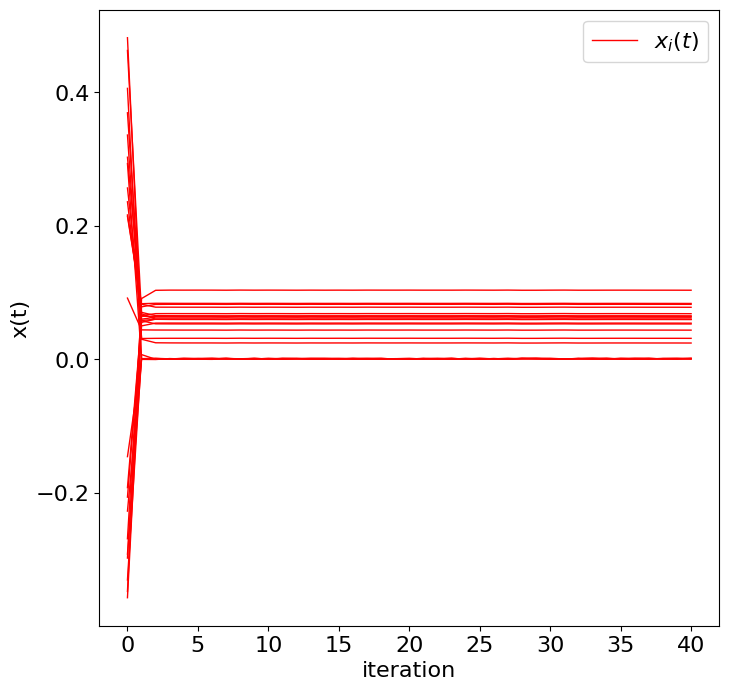

In [51]:
def plot_x(sol_all,count,max_iters):
    t = [i for i in range(max_iters+1)]
    plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 16})
    colors = ['r','g']
    for i in range(count):
        for j in range(22):
            plt.plot(t, sol_all[i][:,0,j],color=colors[i],linewidth=1)
        #plt.plot(t, sol_all[i][:,1],color='g',label=r'$x_{2}(t)$',linewidth=1)
        # plt.plot(t, sol_all[i][:,2],color='b',label=r'$x_{3}(t)$',linewidth=1)
        # plt.plot(t, sol_all[i][:,3],color='y',label=r'$x_{4}(t)$',linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{i}(t)$']) #,r'$x_{3}(t)$',r'$x_{4}(t)$'
    #plt.title("Hôm nay đã đủ mệt cho tối ưu rồi :))")
    plt.show()
plot_x(sol_all,count,max_iters1)

In [52]:
np.sum(sol_all[0][-1,0,:])

1.0000000000000044

In [53]:
f(sol_all[0][-1,0,:])

array([0.15400223])

In [54]:
def ode_solve_G(z0, G):
    """
    Simplest RK4 ODE initial value solver
    """
    n_steps = 200
    z = z0
    h = np.array([0.01])
    for i_step in range(n_steps):
        k1 = h*G(z)
        k2 = h * (G((z+h/2)))
        k3 = h * (G((z+h/2)))
        k4 = h * (G((z+h)))
        k = (1/6)*(k1+2*k2+2*k3+k4)
        z = z + k
    return z
def f(x):
    return (np1.dot(np1.dot(x,Q),x.T))/(np1.dot(p,x.T))
def g1(x):
    return -x[0][0]
def g2(x):
    return -x[0][1]
def g3(x):
    return -x[0][2]
def g4(x):
    return -x[0][3]
def g5(x):
    return -x[0][4]
def g6(x):
    return -x[0][5]
def g7(x):
    return -x[0][6]
def g8(x):
    return -x[0][7]
def g9(x):
    return -x[0][8]
def g10(x):
    return -x[0][9]
def g11(x):
    return -x[0][10]
def g12(x):
    return -x[0][11]
def g13(x):
    return -x[0][12]
def g14(x):
    return -x[0][13]
def g15(x):
    return -x[0][14]
def g16(x):
    return -x[0][15]
def g17(x):
    return -x[0][16]
def g18(x):
    return -x[0][17]
def g19(x):
    return -x[0][18]
def g20(x):
    return -x[0][19]
def g21(x):
    return -x[0][20]
def g22(x):
    return -x[0][21]
f_dx = grad(f)
A = np.ones(22).reshape(1,22)
b = np.array([[1]])
#g1_dx = grad(g1)
g_dx = [grad(g1),grad(g2),grad(g3),grad(g4),grad(g5),grad(g6),grad(g7),grad(g8),grad(g9),grad(g10),grad(g11),grad(g12),grad(g13),grad(g14),grad(g15),grad(g16),grad(g17),grad(g18),grad(g19),grad(g20),grad(g21),grad(g22)]
def Phi(s):
    if s > 0:
        return 1
    elif s == 0:
        return np.random.rand(1)
    return 0
def eq_constraint(x):
    return  np.linalg.norm(A@(x.T) - b, 1)
def G(x):
    # g1x = g1(x)
    # g2x = g2(x)
    # g3x = g3(x)
    # g4x = g4(x)
    # g5x = g5(x)
    #print(x.shape)
    gx = [g1(x),g2(x),g3(x),g4(x),g5(x),g6(x),g7(x),g8(x),g9(x),g10(x),g11(x),g12(x),g13(x),g14(x),g15(x),g16(x),g17(x),g18(x),g19(x),g20(x),g21(x),g22(x)]
    c_xt = 1.
    Px = np.zeros((1, 22))

    for (i,j) in zip(gx, g_dx):
        c_xt *= (1-Phi(i))
        Px += Phi(i)*j(x)
    c_xt *= (1-Phi(np.abs(A@(x.T) - b)))
    
    eq_constr_dx = ((2*Phi(A@(x.T)-b)-1)*A)
    #print(((2*Phi(A@(x.T)-b)-1)*A.T).shape)
    #print(f_dx(x).shape)
    return (-c_xt*f_dx(x) - Px - eq_constr_dx) # tra ve x1'
def run_nonsmooth2(x0, max_iters):
    xt = x0
    res = []
    val = []
    val.append(f(xt))
    res.append(xt.tolist())
    for t in range(max_iters):
        xt = ode_solve_G(xt,G)
        # xt = xt + 0.00001*G(xt)
        # epsi_t = get_epsi(epsi0,f_dx(xt),t)
        # mut = mut*np.exp(-alpha*t)
        res.append(xt.tolist())
        val.append(f(xt))
    print(xt)
    print(np.sum(xt))
    print(f(xt))
    return res,val
num = 1 # number of init points
max_iters = 50 # number of interations
max_iters1 = 50
sol_all,sol_all1 = [],[]
val_all,val_all1 = [],[]
count = 0
epsilon = 0.1
mu0 = np.random.rand(1) # init mu0 
epsi0 = np.random.rand(1) # init epsi0
alpha = np.random.rand(1) # init alpha
n = 22 # dimension x
for i in range(num):
    x0 = np.random.rand(1,n)
    #x0 = find_min(x0,n) # init point
    #x0 = get_x0()
    g1x = g1(x0)
    #print((x0).shape)
    # g2x = g2(x0)
    # g3x = g3(x0)
    # g4x = g4(x0)
    # g5x = g5(x0)
    #print(g1x)
    #print(x0.shape)
    count += 1
    #res,val = run_nonsmooth1_nag(x0, max_iters, f, f_dx,n)
    res,val = run_nonsmooth2(x0, max_iters1)
    tmp = np.array(res)[:,:]
    #tmp1 = np.array(res1)[:,:]
    sol_all.append(tmp)
    val_all.append(val)
    # sol_all1.append(tmp1)
    # val_all1.append(val1)

[[0.0077867  0.00709788 0.00751614 0.00819118 0.00810984 0.00765371
  0.08774776 0.26533563 0.00770372 0.00696549 0.00693664 0.0079223
  0.00830395 0.15160323 0.00740166 0.00749012 0.00793493 0.29149428
  0.00704571 0.07274015 0.00700137 0.00699765]]
0.9969800246073971
[[0.55880918]]


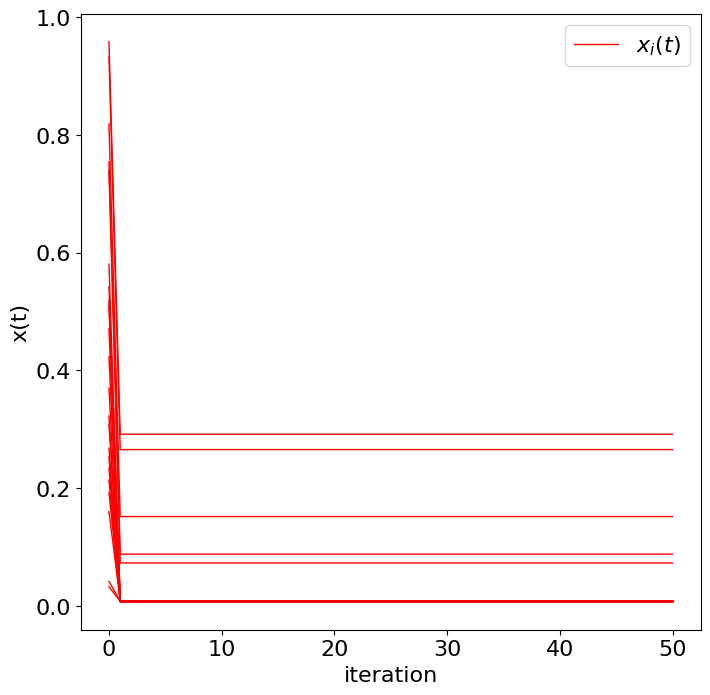

In [55]:
def plot_x(sol_all,count,max_iters):
    t = [i for i in range(max_iters+1)]
    plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 16})
    colors = ['r','g']
    for i in range(count):
        for j in range(22):
            plt.plot(t, sol_all[i][:,0,j],color=colors[i],linewidth=1)
        #plt.plot(t, sol_all[i][:,1],color='g',label=r'$x_{2}(t)$',linewidth=1) 
        # plt.plot(t, sol_all[i][:,2],color='b',label=r'$x_{3}(t)$',linewidth=1)
        # plt.plot(t, sol_all[i][:,3],color='y',label=r'$x_{4}(t)$',linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{i}(t)$']) #,r'$x_{3}(t)$',r'$x_{4}(t)$'
    #plt.title("Hôm nay đã đủ mệt cho tối ưu rồi :))")
    plt.show()
plot_x(sol_all,count,max_iters1)